# Airbus Ship Dataset EDA
This notebook contains the Exploratory Data Analysis of Airbus Ship Dataset.

EDA consists of a variety of techniques and methods to summarize, visualize, and explore the data.

The process involves examining and analyzing a dataset in order to understand 

its main characteristics, uncover patterns, detect anomalies, and gain insights. 

In [1]:
# Importing all the necessary libraries and tools
import numpy as np 
import pandas as pd 
from skimage.data import imread
import matplotlib.pyplot as plt
from pathlib import Path
import os

## **1. Data summary** 
The EDA starts with a basic understanding of the dataset's structure and properties. 

This includes checking the dimensions of the dataset, inspecting the data types of variables, 

and examining the first few rows or a sample of the data.

In [2]:
# Path settings and image counting
ship_dir = '../input'

train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [3]:
# Getting the list of directories/files in dataset folder (/input)
print(os.listdir(ship_dir))

['test_v2', 'sample_submission_v2.csv', 'train_ship_segmentations_v2.csv', 'train_v2']


In [4]:
print(f"Images in train/: {len(os.listdir(train_image_dir))}")
print(f"Images in test/ :  {len(os.listdir(test_image_dir))}")

Images in train/: 192556
Images in test/ :  15606


In [5]:
# Reading the file with the training data
train_df = pd.read_csv('../input/train_ship_segmentations_v2.csv')

In [6]:
# Size of dataframe
train_df.shape

(231723, 2)

In [7]:
# Information about the train dataframe
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
ImageId          231723 non-null object
EncodedPixels    81723 non-null object
dtypes: object(2)
memory usage: 3.5+ MB


At this stage, we can notice many images without any ships.

It could cause some complications during the future steps.

In [8]:
# Look at a content of the file with training data
train_df.head(10)

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5  000194a2d.jpg  198320 10 199088 10 199856 10 200624 10 201392...
6  000194a2d.jpg  55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7  000194a2d.jpg  254389 9 255157 17 255925 17 256693 17 257461 ...
8  0001b1832.jpg                                                NaN
9  00021ddc3.jpg  108287 1 109054 3 109821 4 110588 5 111356 5 1...

In [9]:
# Getting the dataset's image resolution
img = imread('../input/train_v2/00003e153.jpg')
img.shape

(768, 768, 3)

## **2. Data visualization and statistics** 
EDA employs various visualizations to understand the data better. 

This includes histograms, scatter plots, bar charts, box plots, heatmaps, and more.

Visualizations help identify patterns, trends, correlations, and outliers in the data.

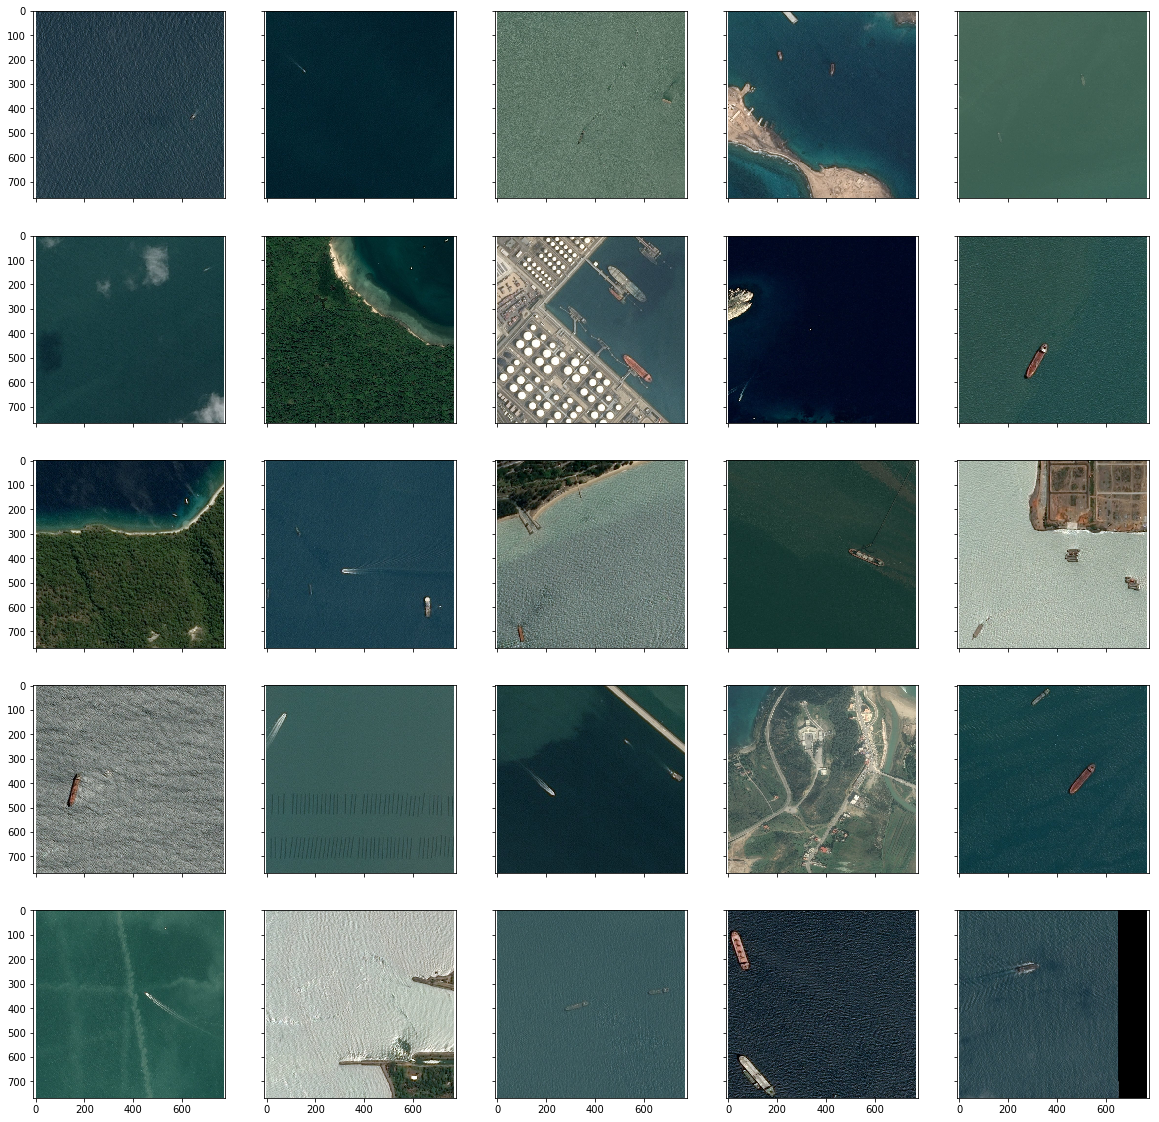

In [10]:
# Looking at 25 images with ships
sample = train_df[~train_df.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, img_id in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path('../input/train_v2') / '{}'.format(img_id)
    img = imread(path)
    
    ax[row, col].imshow(img)

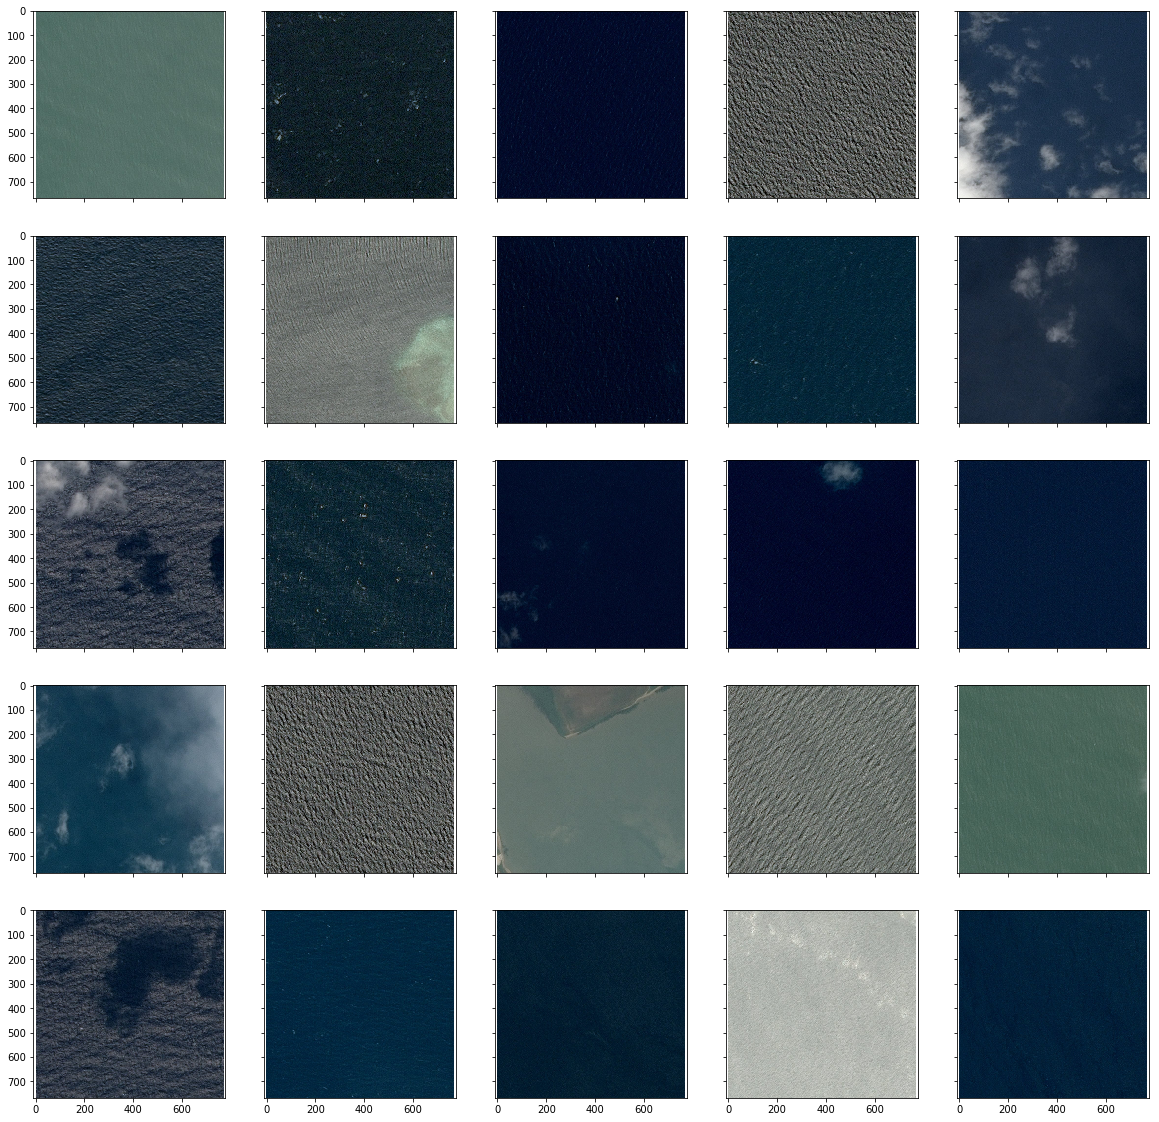

In [11]:
# Looking at 25 images without ships
sample = train_df[train_df.EncodedPixels.isna()].sample(25)

fig, ax = plt.subplots(5, 5, sharex='col', sharey='row')
fig.set_size_inches(20, 20)

for i, imgid in enumerate(sample.ImageId):
    col = i % 5
    row = i // 5
    
    path = Path('../input/train_v2') / '{}'.format(imgid)
    img = imread(path)
    
    ax[row, col].imshow(img)

Text(0,0.5,'Number of Images')

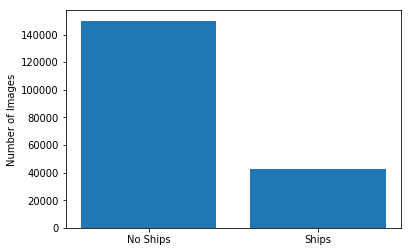

In [12]:
# Let's look at the balance between images with and without ships
ships = train_df[~train_df.EncodedPixels.isna()].ImageId.unique()
noships = train_df[train_df.EncodedPixels.isna()].ImageId.unique()

plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)])
plt.ylabel('Number of Images')

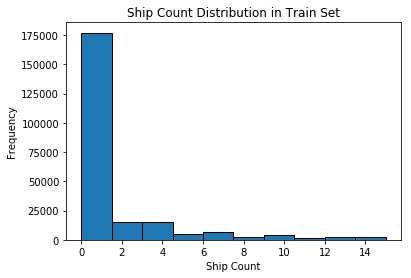

Ship Count Distribution Info
count    231723.000000
mean          1.344472
std           2.755929
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: ship_count, dtype: float64


In [13]:
# Let's look at the distribution of images with different count  ships

# Computing the ship count for each ImageId
train_df['ship_count'] = train_df.groupby('ImageId')['ImageId'].transform('count')
train_df.loc[train_df['EncodedPixels'].isnull().values, 'ship_count'] = 0

# Plotting the ship count distribution
plt.hist(train_df['ship_count'], bins=10, edgecolor='black')
plt.xlabel('Ship Count')
plt.ylabel('Frequency')
plt.title('Ship Count Distribution in Train Set')
plt.show()

# Printing the descriptive statistics of the ship count
print("Ship Count Distribution Info")
print(train_df['ship_count'].describe())

In [14]:
# Function for image mask decoding
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [15]:
def get_img(imgid):
    '''Return image array, given ID.'''
    path = Path('../input/train_v2/') / '{}'.format(imgid)
    return imread(path)

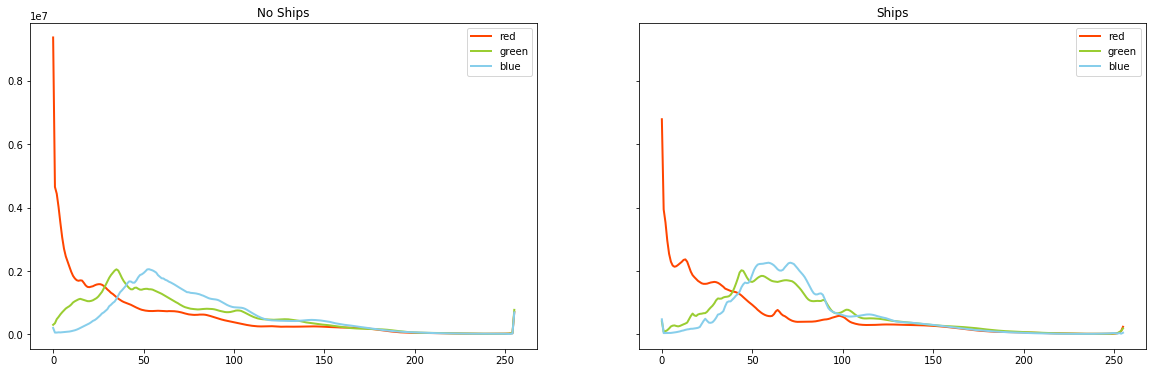

In [16]:
# Look at colour distributions between images with ships and those without.
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
fig.set_size_inches(20, 6)

mask = train_df.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train_df[msk].ImageId.sample(250)
    imgs = np.array([get_img(_id) for _id in _ids])
    
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    ax[i].plot(np.bincount(red.ravel()), color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel()), color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel()), color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)

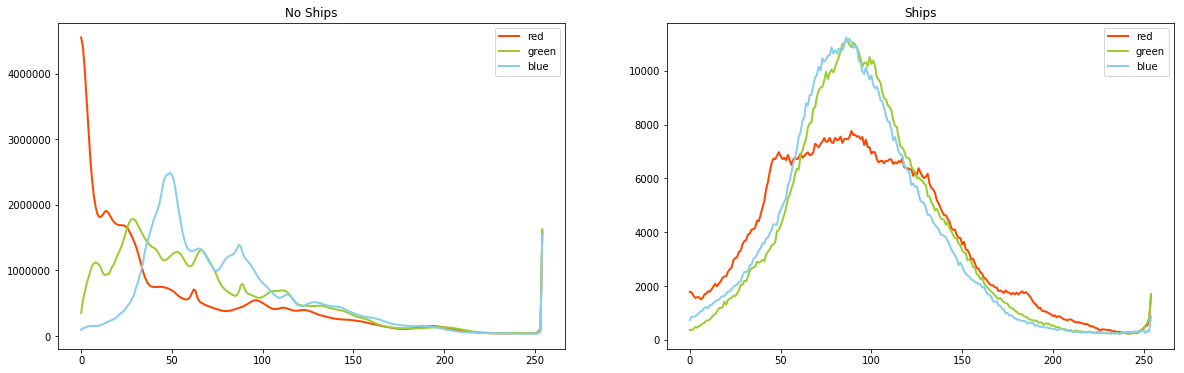

In [17]:
# Look at colour distributions of areas with no ships and ships themselves.
def apply_masks_to_img(img, _id, df):
    '''Apply masks to image given img, its id and the dataframe.'''
    masks = df[df.ImageId == _id].EncodedPixels.apply(lambda x: rle_decode(x)).tolist()
    masks = sum(masks)
    return img * masks.reshape(img.shape[0], img.shape[1], 1)


fig, ax = plt.subplots(1, 2, sharex='col')#, sharey='row')
fig.set_size_inches(20, 6)

mask = train_df.EncodedPixels.isna()
for i, (msk, label) in enumerate(zip([mask, ~mask], ['No Ships', 'Ships'])):
    _ids = train_df[msk].ImageId.sample(250)
    imgs = [get_img(_id) for _id in _ids]
    
    # if we have an encoding to decode
    if i == 1:
        imgs = [apply_masks_to_img(i, _id, train_df) for (i, _id) in zip(imgs, _ids)]

    imgs = np.array(imgs)
    red = imgs[:, :, :, 0]
    green = imgs[:, :, :, 1]
    blue = imgs[:, :, :, 2]
    
    # skip bincount index 0 to avoid the masked pixels to overpower the others.
    ax[i].plot(np.bincount(red.ravel())[1:], color='orangered', label='red', lw=2)
    ax[i].plot(np.bincount(green.ravel())[1:], color='yellowgreen', label='green', lw=2)
    ax[i].plot(np.bincount(blue.ravel())[1:], color='skyblue', label='blue', lw=2)
    ax[i].legend()
    ax[i].title.set_text(label)